# Policy Making in Malaria with AI (beta)

In most areas of public policy and decision making, it’s difficult to make evidence based decisions because of the difficulty involved in exploring options for truly complex decisions. Policy making in malaria is a good example of these complex decisions. In this notebook, we explore policy making with malaria by considering only two interventions space i.e. spraying and using bed nets with an open-malaria model for Rachuonyo South in Western Kenya. A reward function based on cost-effectiveness per Daly averted is used. 

This notebook is structured as follows:

 1. **Running the experiments with random actions** : In this section, we run several experiments with random actions and visualize the outcome reward by creating some MatPlotLib visualisations
 2. **Implementing Machine Learning and AI on models** : We implement a Genetic Algorithm Model after which we look at reward visualization with MatPlotLib

In [1]:
!pip install git+https://github.com/slremy/estool git+https://github.com/slremy/netsapi --user --upgrade
%load_ext autoreload
%autoreload 2    

import numpy as np

from netsapi.challenge import *
from netsapi.visualisation import *
from es import SimpleGA, RemyGA

from sys import exit, exc_info, argv

userId = None

  Cloning https://github.com/slremy/estool to /tmp/pip-req-build-dx5yi1g8
  Cloning https://github.com/slremy/netsapi to /tmp/pip-req-build-9jdjobls
  Running setup.py bdist_wheel for estool ... done
  Stored in directory: /tmp/pip-ephem-wheel-cache-3p0o3l60/wheels/ae/d6/49/601d1979c4702fe2f583735c83f276000b8a4d8d0013ca60fd
  Running setup.py bdist_wheel for netsapi ... done
  Stored in directory: /tmp/pip-ephem-wheel-cache-3p0o3l60/wheels/9e/73/c9/86a9cc2460e11b3ce5b0a5ebd2d9d332a68afe0941659967fa
Successfully built estool netsapi
  Found existing installation: estool 1.0
    Uninstalling estool-1.0:
      Successfully uninstalled estool-1.0
  Found existing installation: netsapi 1.0
    Uninstalling netsapi-1.0:
      Successfully uninstalled netsapi-1.0


# 1. Running the experiments with random actions


**Running our first experiment!**

Let's start with initializing our experiment to generate our experiment id. Then we run a simulation describing a current intervention campaign 55% ITN and 70% IRS coverage and obtain our reward.

In [2]:
actions = np.array([[0.55, 0.70]])
reward = evaluate(actions)
solution = np.append(actions.T, reward)
print(solution)

[ 0.55        0.7        11.56592745]


**Running more experiments with different types of actions**

Let's run experiments with 4 sets of actions [ITN, IRS] and visualise the rewards as a simple scatter of points as a response surface (MatPlotLib may be required but you are free to visualise the data how you see fit)

In [3]:
output = []
actions = np.array([[0.55, 0.70]])
reward = evaluate(actions)
solution = np.append(actions.T, reward)
print(solution)
output.append(solution)

[ 0.55        0.7        12.44594367]


In [4]:
actions = np.array([[0.68, 0.70]])
reward = evaluate(actions)
solution = np.append(actions.T, reward)
print(solution)
output.append(solution)

[ 0.68       0.7       12.7826137]


In [5]:
actions = np.array([[0.6, 0.70]])
reward = evaluate(actions)
solution = np.append(actions.T, reward)
print(solution)
output.append(solution)

[ 0.6         0.7        15.44864514]


In [6]:
actions = np.array([[0.40, 0.70]])
reward = evaluate(actions)
solution = np.append(actions.T, reward)
print(solution)
output.append(solution)

[  0.4          0.7        -10.28224857]


In [7]:
output = np.array(output)
print(output)

[[  0.55         0.7         12.44594367]
 [  0.68         0.7         12.7826137 ]
 [  0.6          0.7         15.44864514]
 [  0.4          0.7        -10.28224857]]


In [8]:
actions = np.empty(shape=(10,2)) #10 actions [ITN, IRS]
actions[:,0] = np.random.rand(10) 
actions[:,1] = .70               #don't change this yet!
rewards = np.array(evaluate(actions))

In [9]:
output = np.hstack((actions,rewards.reshape(-1,1)))
print(output)

[[  0.45599056   0.7          1.01207547]
 [  0.25042532   0.7         -8.93202466]
 [  0.7677593    0.7          1.9332929 ]
 [  0.25883641   0.7        -14.68367808]
 [  0.75665693   0.7          3.92902042]
 [  0.99797418   0.7        -23.50634944]
 [  0.85761834   0.7        -19.81738487]
 [  0.59336645   0.7         14.20344873]
 [  0.37112559   0.7        -20.5415576 ]
 [  0.24156881   0.7         -4.57603959]]


**Visualising rewards**

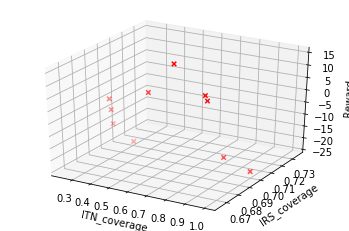

In [10]:
ResponseSurface(output)

# 2. Implementing Machine Learning and AI on models

**Genetic Algorithm**

Implemented in ESTool (Ha, David. "Neuroevolution for deep reinforcement learning problems." Proceedings of the Genetic and Evolutionary Computation Conference Companion. ACM, 2018.)


We use a parameter size of 2, a population size of 20 and consider 10 generations. For each generation we candidate policies to evaluate based on evolutionary pressure, calculate the reward and create a reward vector. We save all the results in a 3 dimensional vector space and aggregate for all generations.

In [11]:
num_paramters = 2

def mutate(chromosome):
    mutation_rate = .1
    for j in range(num_paramters):
        r = np.random.rand(1);
        if(r > mutation_rate):
            chromosome[j] = np.remainder(chromosome[j]+np.random.randn(1),0.99);
    return chromosome

def make_random_individuals(x,y):
    value=np.random.rand(x,y);
    return value


def boundary(individual):
    processed = np.clip(individual,0,1)
    return processed


solver = RemyGA(num_paramters,                # number of model parameters
            random_individuals_fcn=make_random_individuals,
            mutate_fcn = mutate,
            sigma_init=1,        # initial standard deviation
            popsize=20,   # population size
            elite_ratio=0.3,       # percentage of the elites
            forget_best=False,     # forget the historical best elites
            weight_decay=0.00,     # weight decay coefficient
             )

num_generations = 10
history0=  np.empty(shape=(num_generations, solver.popsize, solver.num_params+1))
for i in range(num_generations):
    try:
        # ask for a set of candidate solutions to be evaluated
        solutions = solver.ask(boundary)
        # calculate the reward for each given solution using our own method
        rewards = evaluate(solutions)
        solver.tell(rewards)

        # get best parameter, reward from ES
        reward_vector = solver.result()
        print(reward_vector[0],reward_vector[1],i, num_generations)
        history0[i,:,:] = np.hstack((solutions,np.array(rewards).reshape(-1,1)))
    except (KeyboardInterrupt, SystemExit):
        print(exc_info())

[0.06602341 0.77940213] 88.95665199178977 0 10
[0.06602341 0.77940213] 88.95665199178977 1 10
[0.06602341 0.77940213] 88.95665199178977 2 10
local variable 'reward' referenced before assignment
[0.06602341 0.77940213] 88.95665199178977 3 10
[0.06602341 0.77940213] 94.51644274127663 4 10
[0.06602341 0.77940213] 94.51644274127663 5 10
[0.06602341 0.77940213] 94.51644274127663 6 10
[0.06602341 0.77940213] 94.51644274127663 7 10
[0.06602341 0.77940213] 94.51644274127663 8 10
[0.00277118 0.9193269 ] 95.37474972582643 9 10


**Visualization of reward vectors**

Let's investigate the shape of our result vector

In [12]:
history0.shape

(10, 20, 3)

Let's reshape our result vector so as to visualize the results for all of the 10 generations in one plot

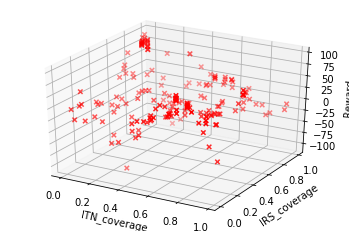

In [13]:
ResponseSurface(history0.reshape(200,3))

And finally we are going to visialize the 10 generations in a box plot.

Remember, as you "evolve" your solutions, you're looking for the best. 

Do you see any evidence of that in this plot?

/home/ero/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/ero/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1246: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = np.compress(x <= hival, x)
/home/ero/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1253: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = np.compress(x >= loval, x)
/home/ero/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1261: RuntimeWarning: invalid value encountered in less
  np.compress(x < stats['whislo'], x),
/home/ero/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1262: RuntimeWarning: invalid value encountered in greater
  np.compress(x > stats['whishi'], x)


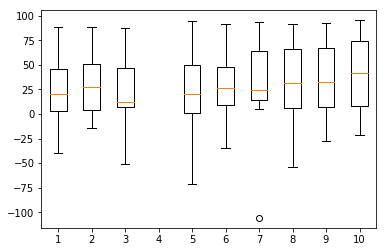

In [14]:
plt.boxplot([i[:,-1] for i in history0]);

## Now time to try and break it! 

You're now free to explore! Given the code snippets of how to post single actions.
Several methods, approaches or algorithms may stand to benefit the uses of high bandwidth computation for machine learning.

In [15]:
popsize=10
num_real_paramters = 2
width = 10
num_paramters = num_real_paramters * width
num_generations = 10

#converts from binary representation to the actual action
def RealAction(action):
    realaction=()
    for i in range(int(num_paramters/width)):
        a1 = np.array(action[i*width:(i+1)*width])
        realaction = realaction + (a1.dot(2**np.arange(a1.size)[::-1])/pow(2,width),)
    realaction = np.round(realaction,3);
    return realaction

def mutate(chromosome):
    mutation_rate = .2
    for j in range(chromosome.shape[0]):
        r = np.random.rand(1);
        if(r > mutation_rate):
            chromosome[j] = int(np.invert(bool(chromosome[j])));
    return chromosome

def make_random_individuals(x,y):
    value=np.random.choice([0, 1], size=(x,y));
    return value

def boundary(individual):
    processed = individual%(1+np.finfo(float).eps)
    return processed

solver = RemyGA(num_paramters,         # number of model parameters
                random_individuals_fcn=make_random_individuals,
                mutate_fcn = mutate,
                sigma_init=1,          # initial standard deviation
                popsize=popsize,       # population size
                elite_ratio=0.3,       # percentage of the elites
                forget_best=False,     # forget the historical best elites
                weight_decay=0.00,     # weight decay coefficient
                )

history1=  np.empty(shape=(num_generations, popsize, num_real_paramters+1))
for i in range(num_generations):
    try:
        # ask for a set of random candidate solutions to be evaluated
        solutions = solver.ask(boundary)
        # calculate the reward for each given solution using our own method
        newsolutions = []
        for soln in solutions:
            newsolutions.append(RealAction(soln))
        newsolutions = np.array(newsolutions)
        rewards = evaluate(newsolutions)
        solver.tell(rewards)
        
        # get best parameter, reward from ES
        reward_vector = solver.result()
        print(RealAction(reward_vector[0]), reward_vector[1], i, num_generations)
        history1[i,:,:] = np.hstack((newsolutions,np.array(rewards).reshape(-1,1)))
    except (KeyboardInterrupt, SystemExit):
        print(exc_info())

[0.114 0.762] 55.58776072818011 0 10
[0.114 0.762] 66.58314197111683 1 10
[0.114 0.762] 66.58314197111683 2 10
[0.068 0.992] 79.07993176573196 3 10
[0.068 0.992] 80.8179522440997 4 10
[0.068 0.992] 80.8179522440997 5 10
[0.068 0.992] 86.0320136792029 6 10
[0.068 0.992] 86.0320136792029 7 10
[0.068 0.992] 90.37706487512224 8 10
[0.068 0.992] 90.37706487512224 9 10


In [16]:
newdata=history1.reshape(num_generations*popsize,num_real_paramters+1)

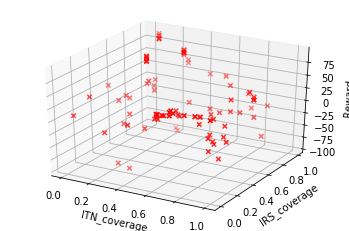

In [17]:
ResponseSurface(newdata)